In [1]:
import quandl
quandl.ApiConfig.api_key = 'u8RPsWkhvPm8DZHKzWPH'

import datetime as dt
import pandas as pd
import pandas_datareader.data as pdd

start=dt.datetime(2010,1,1)
end=dt.datetime(2017,12,31)

#list of stocks
#in this preview, I only ran a list with first 10 stocks of the 20 since I dont have GPU support and PC crashes when I run 20..
#re-run the whole code for complete result
lst=['AAPL','AMZN','MSFT','JPM','GOOGL','BA','LMT','WMT','C','IBM']

dfdc={}
raw={}
for i in lst:
    df=pdd.DataReader(i, "quandl",start,end,api_key = 'u8RPsWkhvPm8DZHKzWPH')
    
    #the data is in reverse order
    raw[i]=df.iloc[::-1]
    dfdc[i]=raw[i].copy(deep=True)


In [2]:
import numpy as np
import ta as ta

lags=5
# Adding indicators
for i in dfdc:
    dfdc[i]['RSI']=ta.momentum.rsi(dfdc[i]['AdjClose'])
    dfdc[i]['ADX']=ta.trend.adx(dfdc[i]['AdjHigh'],dfdc[i]['AdjLow'],dfdc[i]['AdjClose'])
    dfdc[i]['PSAR_UP']=ta.trend.psar_up(dfdc[i]['AdjHigh'],dfdc[i]['AdjLow'],dfdc[i]['AdjClose'])
    dfdc[i]['PSAR_DOWN']=ta.trend.psar_down(dfdc[i]['AdjHigh'],dfdc[i]['AdjLow'],dfdc[i]['AdjClose'])
    dfdc[i]['EMA']=ta.trend.ema_indicator(dfdc[i]['AdjClose'],5,False)
    dfdc[i]['MACD']=ta.trend.macd(dfdc[i]['AdjClose'],12,26,False)
    dfdc[i]['ATR']=ta.volatility.average_true_range(dfdc[i]['AdjHigh'],dfdc[i]['AdjLow'],dfdc[i]['AdjClose'],14)
    dfdc[i]['SO']=ta.momentum.stoch(dfdc[i]['AdjHigh'],dfdc[i]['AdjLow'],dfdc[i]['AdjClose'],14)
    

c:\users\zmhe\appdata\local\programs\python\python37\lib\site-packages\ta\trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\zmhe\appdata\local\programs\python\python37\lib\site-packages\ta\trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [3]:
#clean things up
for i in dfdc:
    dfdc[i].fillna(0,inplace=True)
    #ADX is NaN until 2010-02-11 due to its formula
    dfdc[i].drop(dfdc[i].iloc[:27].index,axis=0,inplace=True)
    #only keep revelant data
    dfdc[i].drop(['Open', 'High', 'Low', 'Close', 'Volume', 'ExDividend', 'SplitRatio',
       'AdjOpen', 'AdjHigh', 'AdjLow', 'AdjVolume'],axis=1,inplace=True)
    

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler=MinMaxScaler(feature_range=(0,1))

#set up empty dictionaries for all types of data will be in dict form
stock={}
trainX={}
testX={}
trainY={}
testY={}
train_data1={}
train_data={}
test_data1={}
test_data={}

#set train/test split portions
train_portion=0.8

#set timestep
ts=5

#split train/test sets
#could alternatively use train_test_split here yet I wish to nomallize train set all together so
for i in dfdc:
    #transform to ndarray for easier modification
    stock[i]=dfdc[i].values
    
    splt=round(stock[i].shape[0]*train_portion)
    
    #split the data in a non-elegant way :/
    train_data1[i]=stock[i][:splt]
    train_data[i]=scaler.fit_transform(train_data1[i])
    test_data1[i]=stock[i][splt:]
    test_data[i]=scaler.transform(test_data1[i])
    
#set shape
for i in dfdc:

    trainX[i]=np.empty(shape=((train_data[i].shape[0]-ts),ts,(train_data[i].shape[1]-1)))
    testX[i]=np.empty(shape=((test_data[i].shape[0]-ts),ts,(test_data[i].shape[1]-1)))
    trainY[i]=np.empty(shape=((train_data[i].shape[0]-ts)))
    testY[i]=np.empty(shape=((test_data[i].shape[0]-ts)))    

#sliding window/timestep
for i in dfdc:
    #x data, with first entry being lines [0:5,1:9], data from line 1-5
    #5 lines x 8 features
    for j in range(ts-1,(len(trainX[i])-1)):
        trainX[i][j-ts+1]=np.vstack(train_data[i][j-ts+1:j+1,1:9])
        
    for j in range(ts-1,(len(testX[i])-1)):
        testX[i][j-ts+1]=np.vstack(test_data[i][j-ts+1:j+1,1:9])
        
    #y data, with first entry being [5], the price data on the 6th line
    trainY[i]=train_data[i][ts:,0]
    testY[i]=test_data[i][ts:,0]
    

Using TensorFlow backend.


Train on 1582 samples, validate on 392 samples
Epoch 1/50
1582/1582 [==============================] - 1s 697us/step - loss: 0.2842 - accuracy: 6.3211e-04 - val_loss: 0.5527 - val_accuracy: 0.0000e+00
Epoch 2/50
1582/1582 [==============================] - 0s 124us/step - loss: 0.2531 - accuracy: 0.0013 - val_loss: 0.4325 - val_accuracy: 0.0000e+00
Epoch 3/50
1582/1582 [==============================] - 0s 123us/step - loss: 0.1500 - accuracy: 0.0013 - val_loss: 0.1427 - val_accuracy: 0.0000e+00
Epoch 4/50
1582/1582 [==============================] - 0s 120us/step - loss: 0.0973 - accuracy: 0.0013 - val_loss: 0.1976 - val_accuracy: 0.0000e+00
Epoch 5/50
1582/1582 [==============================] - 0s 123us/step - loss: 0.0830 - accuracy: 0.0013 - val_loss: 0.1767 - val_accuracy: 0.0000e+00
Epoch 6/50
1582/1582 [==============================] - 0s 132us/step - loss: 0.0730 - accuracy: 0.0013 - val_loss: 0.1634 - val_accuracy: 0.0000e+00
Epoch 7/50
1582/1582 [===========================

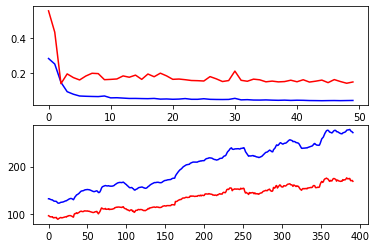

Train on 1582 samples, validate on 392 samples
Epoch 1/50
1582/1582 [==============================] - 1s 691us/step - loss: 0.2643 - accuracy: 6.3211e-04 - val_loss: 0.8329 - val_accuracy: 0.0000e+00
Epoch 2/50
1582/1582 [==============================] - 0s 122us/step - loss: 0.2164 - accuracy: 6.3211e-04 - val_loss: 0.6701 - val_accuracy: 0.0000e+00
Epoch 3/50
1582/1582 [==============================] - 0s 120us/step - loss: 0.1205 - accuracy: 6.3211e-04 - val_loss: 0.3136 - val_accuracy: 0.0000e+00
Epoch 4/50
1582/1582 [==============================] - 0s 127us/step - loss: 0.0929 - accuracy: 6.3211e-04 - val_loss: 0.4090 - val_accuracy: 0.0000e+00
Epoch 5/50
1582/1582 [==============================] - 0s 120us/step - loss: 0.0779 - accuracy: 6.3211e-04 - val_loss: 0.4274 - val_accuracy: 0.0000e+00
Epoch 6/50
1582/1582 [==============================] - 0s 123us/step - loss: 0.0729 - accuracy: 6.3211e-04 - val_loss: 0.4059 - val_accuracy: 0.0000e+00
Epoch 7/50
1582/1582 [=======

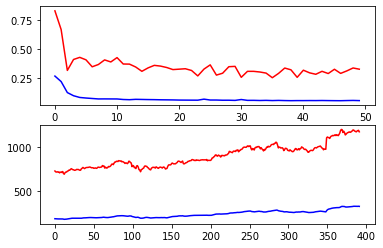

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 714us/step - loss: 0.2963 - accuracy: 6.3171e-04 - val_loss: 0.9835 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 131us/step - loss: 0.2516 - accuracy: 0.0013 - val_loss: 0.7347 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 126us/step - loss: 0.1373 - accuracy: 0.0013 - val_loss: 0.2885 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 125us/step - loss: 0.0944 - accuracy: 0.0013 - val_loss: 0.3832 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 129us/step - loss: 0.0829 - accuracy: 0.0013 - val_loss: 0.3602 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 135us/step - loss: 0.0791 - accuracy: 0.0013 - val_loss: 0.3345 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [===========================

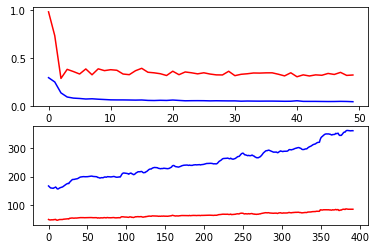

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 688us/step - loss: 0.3269 - accuracy: 0.0013 - val_loss: 0.9631 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 143us/step - loss: 0.2730 - accuracy: 0.0000e+00 - val_loss: 0.8198 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 137us/step - loss: 0.2095 - accuracy: 0.0013 - val_loss: 0.4967 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 144us/step - loss: 0.1155 - accuracy: 0.0013 - val_loss: 0.4878 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 128us/step - loss: 0.0956 - accuracy: 0.0013 - val_loss: 0.3753 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 127us/step - loss: 0.0860 - accuracy: 0.0013 - val_loss: 0.3828 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [===========================

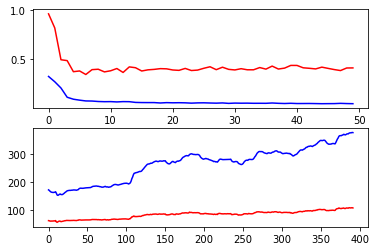

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 716us/step - loss: 0.3011 - accuracy: 6.3171e-04 - val_loss: 0.7061 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 145us/step - loss: 0.2623 - accuracy: 0.0013 - val_loss: 0.6100 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 137us/step - loss: 0.1516 - accuracy: 0.0013 - val_loss: 0.2431 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 134us/step - loss: 0.0970 - accuracy: 0.0013 - val_loss: 0.2053 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 135us/step - loss: 0.0864 - accuracy: 0.0013 - val_loss: 0.2840 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 146us/step - loss: 0.0795 - accuracy: 0.0013 - val_loss: 0.2706 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [===========================

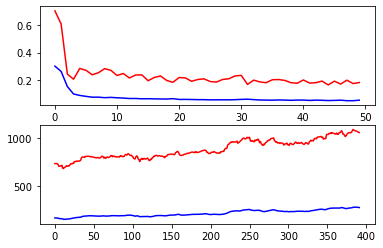

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 750us/step - loss: 0.3372 - accuracy: 6.3171e-04 - val_loss: 0.8821 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 143us/step - loss: 0.2712 - accuracy: 6.3171e-04 - val_loss: 0.5452 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 151us/step - loss: 0.1332 - accuracy: 0.0013 - val_loss: 0.4009 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 147us/step - loss: 0.1151 - accuracy: 0.0013 - val_loss: 0.3673 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 148us/step - loss: 0.0918 - accuracy: 0.0013 - val_loss: 0.4124 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 161us/step - loss: 0.0816 - accuracy: 0.0013 - val_loss: 0.4326 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [=======================

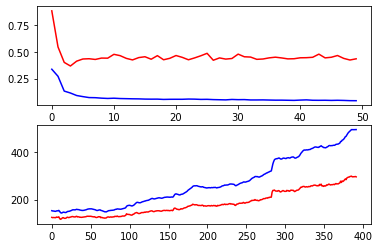

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 717us/step - loss: 0.3567 - accuracy: 6.3171e-04 - val_loss: 0.9374 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 148us/step - loss: 0.2892 - accuracy: 6.3171e-04 - val_loss: 0.6580 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 147us/step - loss: 0.1614 - accuracy: 0.0013 - val_loss: 0.1451 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 147us/step - loss: 0.1031 - accuracy: 0.0013 - val_loss: 0.2988 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 150us/step - loss: 0.0870 - accuracy: 0.0013 - val_loss: 0.3295 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 151us/step - loss: 0.0815 - accuracy: 0.0013 - val_loss: 0.2676 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [=======================

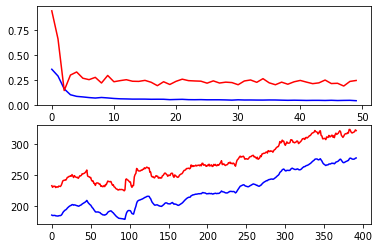

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 706us/step - loss: 0.2748 - accuracy: 6.3171e-04 - val_loss: 0.3432 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 144us/step - loss: 0.2452 - accuracy: 0.0013 - val_loss: 0.2829 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 143us/step - loss: 0.1605 - accuracy: 0.0013 - val_loss: 0.1048 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 142us/step - loss: 0.1021 - accuracy: 0.0013 - val_loss: 0.1274 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 142us/step - loss: 0.0829 - accuracy: 0.0013 - val_loss: 0.0967 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 144us/step - loss: 0.0751 - accuracy: 0.0013 - val_loss: 0.1021 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [===========================

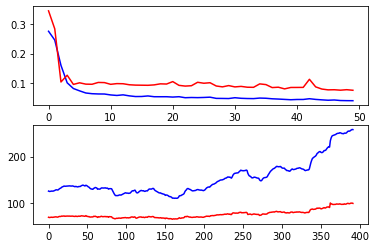

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 723us/step - loss: 0.2822 - accuracy: 6.3171e-04 - val_loss: 0.5178 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 160us/step - loss: 0.2305 - accuracy: 0.0013 - val_loss: 0.3997 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 145us/step - loss: 0.1891 - accuracy: 6.3171e-04 - val_loss: 0.2377 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 146us/step - loss: 0.1187 - accuracy: 0.0013 - val_loss: 0.1706 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 156us/step - loss: 0.0986 - accuracy: 0.0013 - val_loss: 0.1735 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 150us/step - loss: 0.0858 - accuracy: 0.0013 - val_loss: 0.1913 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [=======================

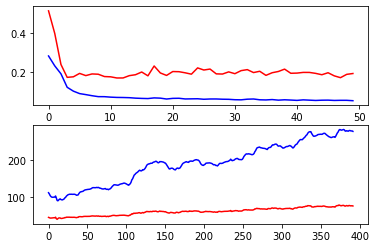

Train on 1583 samples, validate on 392 samples
Epoch 1/50
1583/1583 [==============================] - 1s 751us/step - loss: 0.3008 - accuracy: 6.3171e-04 - val_loss: 0.1559 - val_accuracy: 0.0000e+00
Epoch 2/50
1583/1583 [==============================] - 0s 157us/step - loss: 0.2571 - accuracy: 0.0013 - val_loss: 0.0894 - val_accuracy: 0.0000e+00
Epoch 3/50
1583/1583 [==============================] - 0s 153us/step - loss: 0.2107 - accuracy: 0.0013 - val_loss: 0.0645 - val_accuracy: 0.0000e+00
Epoch 4/50
1583/1583 [==============================] - 0s 148us/step - loss: 0.1176 - accuracy: 0.0013 - val_loss: 0.0771 - val_accuracy: 0.0000e+00
Epoch 5/50
1583/1583 [==============================] - 0s 187us/step - loss: 0.0932 - accuracy: 0.0013 - val_loss: 0.0598 - val_accuracy: 0.0000e+00
Epoch 6/50
1583/1583 [==============================] - 0s 144us/step - loss: 0.0850 - accuracy: 0.0013 - val_loss: 0.0612 - val_accuracy: 0.0000e+00
Epoch 7/50
1583/1583 [===========================

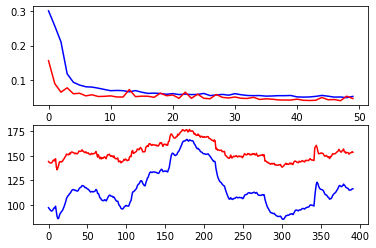

In [5]:
import tensorflow as tf
import keras as ks
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras import regularizers
from keras import backend as K

predicted_price={}
pdp={}

#defining rmse loss function, the one that author used, not in the package
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

for i in dfdc:
    model = Sequential()
    model.add(LSTM(40, input_shape=(trainX[i].shape[1],trainX[i].shape[2]),return_sequences=True))
    
    #used sigmoid here to slightly boost learning speed
    model.add(Dropout(0.2))
    model.add(LSTM(80,activation='sigmoid',return_sequences=True))
    
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='relu'))
    
    #did not set learn rate here since the author did not (and Im too lazy to)
    model.compile(loss=rmse, optimizer='adam',metrics=['accuracy'])
    history=model.fit(x=trainX[i], y=trainY[i], epochs=50, batch_size=80,validation_data=(testX[i],testY[i]))
    
    #plot train/test loss curve
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='train',color='b')
    plt.plot(history.history['val_loss'], label='test',color='r')

    #predicting
    predicted_price[i] = model.predict(x=testX[i])
    
    #De-normalize
    pdp[i]= scaler.inverse_transform(np.concatenate((test_data[i][5:,1:9],predicted_price[i]),axis=1))
    pdp[i]=pdp[i][:,4]

    #plot predicted vs. actual stock price on test data
    plt.subplot(2,1,2)
    plt.plot(test_data1[i][ts:,0],color='red', label='Real Return')
    plt.plot(pdp[i],color='blue', label='Predicted Return')
    plt.show()



In [6]:
result={}
res= pd.DataFrame(index=lst,columns=['rate','return'])

for i in dfdc:
    result[i]= pd.DataFrame(columns=['predicted price','real price','predicted return','real return','predicted UD','real UD','correct','ret']) 
    result[i]['predicted price']=pdp[i]
    result[i]['real price']=test_data1[i][ts:,0]
    result[i]['predicted return']=(result[i]['predicted price']-result[i]['predicted price'].shift(1))/result[i]['predicted price'].shift(1)
    result[i]['real return']=(result[i]['real price']- result[i]['real price'].shift(1))/ result[i]['real price']
    result[i].loc[[0],['ret']]=1
    
    leng=result[i].shape[0]
    for j in range(0,leng-1):    
        if result[i]['predicted return'][j]>0:
            result[i].loc[[j],['predicted UD']]=1 
        else:
            result[i].loc[[j],['predicted UD']]=0
    for j in range(0,leng-1):   
        if result[i]['real return'][j]>0:
            result[i].loc[[j],['real UD']]=1
        else:
            result[i].loc[[j],['real UD']]=0
    for j in range(0,leng-1):
        if result[i]['predicted UD'][j]==result[i]['real UD'][j]:
            result[i].loc[[j],['correct']]=1
        else:
            result[i].loc[[j],['correct']]=0
            
    #regarding return, we assume we have infinite liquidity, zero fees, and ability to go long and short
    for j in range(1,leng-1):
        if result[i]['predicted UD'][j]==1:
            result[i].loc[[j],['ret']]=result[i]['ret'][j-1]*(1+result[i]['real return'][j])
        if result[i]['predicted UD'][j]==0:
            result[i].loc[[j],['ret']]=result[i]['ret'][j-1]*(1+(-1*result[i]['real return'][j]))   
    
    result[i].dropna(inplace=True)
    res.loc[[i],['rate']]=sum(result[i]['correct'][:])/len(result[i]['correct'])      
    res.loc[[i],['return']]=result[i]['ret'].iloc[-1]

    
        


In [7]:
#print correct rate for daily trend (Up/Down) prediction and theoretical return if invest $1 on day one, compounded daily
res

,rate,return
AAPL,0.728205,9.1683
AMZN,0.758974,12.3277
MSFT,0.75641,7.4602
JPM,0.735897,8.70171
GOOGL,0.735897,7.52421
BA,0.723077,8.09038
LMT,0.751282,5.59258
WMT,0.774359,6.91319
C,0.723077,13.4447
IBM,0.748718,6.04383


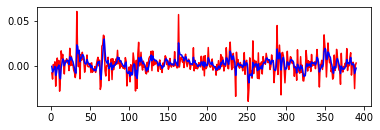

In [8]:
#ploting pred/actual qi(return) to compare with the one in the essay
#take AAPL as an example, which is the stock that the author used
plt.subplot(2,1,2)
plt.plot(result['AAPL']['real return'],color='red', label='Real Return')
plt.plot(result['AAPL']['predicted return'],color='blue', label='Predicted Return')
plt.show()

In [9]:
#Some extra code to see if the train x and y took data from the same day

In [10]:
train_data['AAPL'][0:6,0:9]

array([[0.00203762, 0.36624861, 0.41593098, 0.        , 0.20686864,
        0.        , 0.59331968, 0.06837512, 0.35890878],
       [0.00420045, 0.39948847, 0.3869836 , 0.        , 0.20621573,
        0.0016527 , 0.58603939, 0.06964724, 0.43179881],
       [0.00802019, 0.4557496 , 0.35157208, 0.        , 0.20558893,
        0.0040425 , 0.57628069, 0.06421673, 0.64682735],
       [0.0069451 , 0.439102  , 0.32132236, 0.        , 0.20498721,
        0.00527318, 0.56915113, 0.05950119, 0.80655738],
       [0.0074232 , 0.4466113 , 0.29323334, 0.        , 0.20462769,
        0.00625485, 0.56274758, 0.05400104, 0.90170697],
       [0.00583206, 0.41963932, 0.26715068, 0.        , 0.20462769,
        0.00637277, 0.55887108, 0.0468378 , 0.8038633 ]])

In [11]:
#expecting train_data[0:5,1:9] where last array from previous printout is excludedtrain_data
trainX['AAPL'][0]

array([[0.36624861, 0.41593098, 0.        , 0.20686864, 0.        ,
        0.59331968, 0.06837512, 0.35890878],
       [0.39948847, 0.3869836 , 0.        , 0.20621573, 0.0016527 ,
        0.58603939, 0.06964724, 0.43179881],
       [0.4557496 , 0.35157208, 0.        , 0.20558893, 0.0040425 ,
        0.57628069, 0.06421673, 0.64682735],
       [0.439102  , 0.32132236, 0.        , 0.20498721, 0.00527318,
        0.56915113, 0.05950119, 0.80655738],
       [0.4466113 , 0.29323334, 0.        , 0.20462769, 0.00625485,
        0.56274758, 0.05400104, 0.90170697]])

In [12]:
#expecting train_data[5,0], the first object in the last line in previous printout
trainY['AAPL'][0]

0.005832062494591034